In [2]:
import numpy as np

def gibbs_biv_normal(nchain, mean, var_cov, init = [0, 0]):
    ## Cette fonction simule une chaine de Markov via Gibbs dont la loi stationnaire est une Normale bivariée d'espérance mean et de variance covariance var_cov.

    ## Initialisation des variables
    chain = np.zeros((nchain + 1, 2))
    chain[0,:] = mean##initialisation de la chaine en son état initial
    var = np.diag(var_cov)
    corr = var_cov[0,1] / np.sqrt(var[0] * var[1])


    for t in range(nchain):
        chain[t+1,:] = chain[t,:]##mon nouvel état est le même que celui d'avant

        # Mise à jour de X1 | X2, ici on utilise les formules des lois conditionnelles de la gaussienne
        mean_cond = mean[0] + corr * np.sqrt(var[0] / var[1]) * (chain[t+1,1] - mean[1])
        var_cond = var[0] * (1 - corr**2)

        chain[t+1,0] = np.random.normal(loc = mean_cond, scale = np.sqrt(var_cond))

        # Mise à jour de X2 | X1 ici on utilise les formules des lois conditionnelles de la gaussienne
        #
        ## Attention : ici on simule bien selon la loi de X2 | X1 = chain[t+1,0] (celle que l'on vient de mettre à jour juste avant !!!)
        mean_cond = mean[1] + corr * np.sqrt(var[1] / var[0]) * (chain[t+1,0] - mean[0])
        var_cond = var[1] * (1 - corr**2)

        chain[t+1,1] = np.random.normal(loc = mean_cond, scale = np.sqrt(var_cond))
    
    return chain


In [3]:
mu = [1, -1]
Sigma = np.array([[3, 2.5], [2.5, 7]])
nchain = 10**4
chain = gibbs_biv_normal(nchain, mu, Sigma)

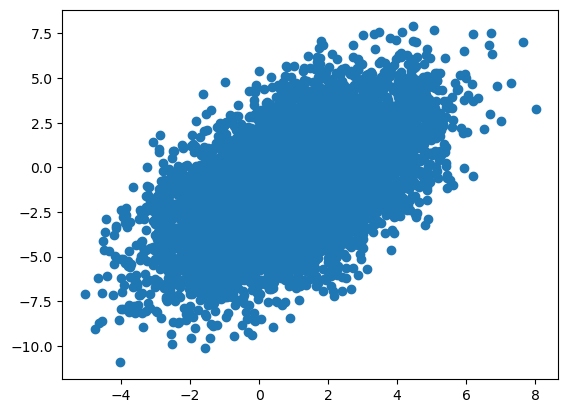

In [6]:
import matplotlib.pyplot as plt
plt.scatter(chain[:,0], chain[:,1])


In [12]:
np.mean(chain, axis=0)
np.cov(chain.T)

array([[3.02015074, 2.50248929],
       [2.50248929, 6.87108096]])

In [15]:
## Exercice 6 (le plus débile du monde)
import scipy.stats as stats
def mh_within_gibbs_biv_normal(nchain, mean, var_cov, init = [0, 0], prop_sd = [1, 1]):
    ## Cette fonction simule une chaine de Markov via un M.-H. within Gibbs dont la loi stationnaire est une Normale bivariée d'espérance mean et de variance covariance var_cov.

    ## Initialisation des variables
    acc_rate = np.zeros(2)
    chain = np.zeros((nchain + 1, 2))
    chain[0,:] = mean##initialisation de la chaine en son état initial
    var = np.diag(var_cov)
    corr = var_cov[0,1] / np.sqrt(var[0] * var[1])


    for t in range(nchain):
        current = chain[t,:]##l'état actuel de ma chaine

        # Mise à jour de X1 | X2, ici on propose selon un M.-H.
        
        ## Ma loi cible ici est la loi conditionnelle X1 | X2, i.e., une gaussien de paramètre
        mean_cond = mean[0] + corr * np.sqrt(var[0] / var[1]) * (current[1] - mean[1])
        var_cond = var[0] * (1 - corr**2)
        
        ## Générons un candidat
        prop = np.random.normal(current[0], prop_sd[0])
        
        ## Calcul de la proba d'acceptation (ici noyau symétrique donc K(X*, Xt) / K(Xt, X*) = 1
        acc_prob = np.exp(stats.norm.logpdf(prop, mean_cond, np.sqrt(var_cond)) - stats.norm.logpdf(current[0], mean_cond, np.sqrt(var_cond)))
        
        ## Mise à jour
        if np.random.uniform() < acc_prob:
            current[0] = prop
            acc_rate[0] += 1
        

        # Mise à jour de X2 | X1, ici on propose selon un M.-H.
        
        ## Ma loi cible ici est la loi conditionnelle X2 | X1, i.e., une gaussien de paramètre
        mean_cond = mean[1] + corr * np.sqrt(var[1] / var[0]) * (current[0] - mean[0])
        var_cond = var[1] * (1 - corr**2)
        
        ## Générons un candidat
        prop = np.random.normal(current[1], prop_sd[1])
        
        ## Calcul de la proba d'acceptation (ici noyau symétrique donc K(X*, Xt) / K(Xt, X*) = 1
        acc_prob = np.exp(stats.norm.logpdf(prop, mean_cond, np.sqrt(var_cond)) - stats.norm.logpdf(current[0], mean_cond, np.sqrt(var_cond)))
        
        ## Mise à jour
        if np.random.uniform() < acc_prob:
            current[1] = prop
            acc_rate[1] += 1
            
        ## Mets à jour la chaine
        chain[t+1,:] = current
    
    return chain, acc_rate / nchain

In [26]:
mu = [1, -1]
Sigma = np.array([[3, 2.5], [2.5, 7]])
nchain = 10**4
chain, acc_rate = mh_within_gibbs_biv_normal(nchain, mu, Sigma, prop_sd=[5, 8])

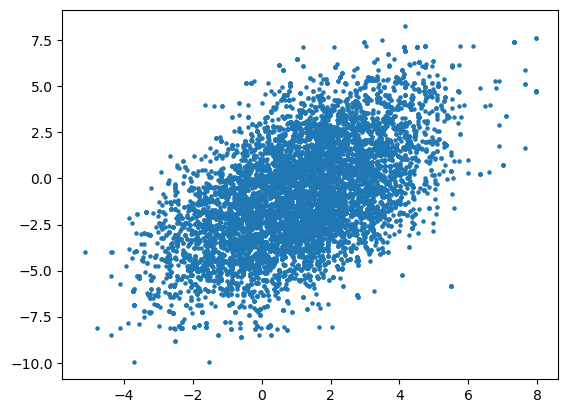

In [27]:
plt.scatter(chain[:,0], chain[:,1], s = 5)

In [28]:
acc_rate

array([0.3382, 0.3141])

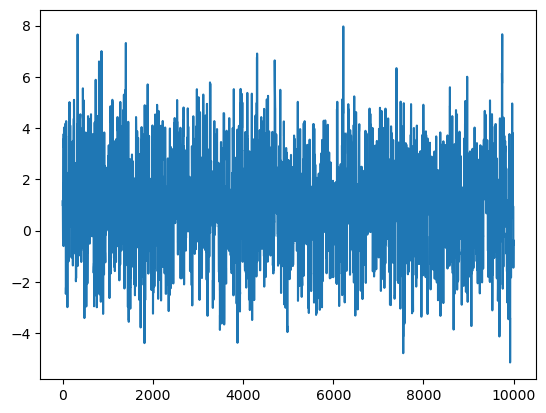

In [29]:
plt.plot(chain[:,0])

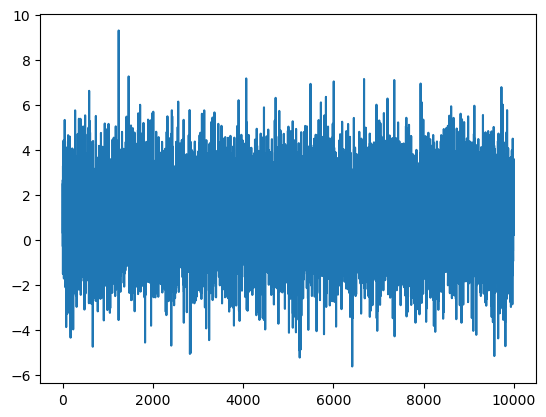

In [21]:
plt.plot(np.random.normal(1, np.sqrt(3), size = 10**4))